In [117]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.animation import PillowWriter, FuncAnimation
from typing import List

np.set_printoptions(precision=3, suppress=True)

In [43]:
def get_temperature_matrix(m: int, n: int,
                           delta_x: float, delta_y: float, delta_t: float) -> np.ndarray:
    a_p = (delta_x * delta_y) ** 2 + 2 * delta_t * (delta_x ** 2 + delta_y ** 2)
    b_p = - delta_t * delta_x ** 2
    c_p = - delta_t * delta_y ** 2

    l = m * n
    res = np.zeros((l, l))
    for i in range(m):
        for j in range(n):
            p = n * i + j
            res[p][p] = a_p

            if i > 0:
                res[p][p - n] = c_p
            if i < m - 1:
                res[p][p + n] = c_p
            if j > 0:
                res[p][p - 1] = b_p
            if j < n - 1:
                res[p][p + 1] = b_p

    return res


def get_boundary_vector(m: int, n: int,
                        delta_x: float, delta_y: float, delta_t: float,
                        left: np.ndarray, right: np.ndarray,
                        up: np.ndarray, bottom: np.ndarray) -> np.ndarray:
    b_p = - delta_t * delta_x ** 2
    c_p = - delta_t * delta_y ** 2

    res = np.zeros(m * n)
    for i in range(m):
        for j in range(n):
            p = n * i + j
            if i == 0:
                res[p] -= bottom[j] * c_p
            if j == 0:
                res[p] -= left[i] * b_p
            if i == m - 1:
                res[p] -= up[j] * c_p
            if j == n - 1:
                res[p] -= right[i] * b_p

    return res

Generation finished, saving...
1 frame processed!
1 frame processed!
2 frame processed!
3 frame processed!
4 frame processed!
5 frame processed!
6 frame processed!
7 frame processed!
8 frame processed!
9 frame processed!
10 frame processed!
11 frame processed!
12 frame processed!
13 frame processed!
14 frame processed!
15 frame processed!
16 frame processed!
17 frame processed!
18 frame processed!
19 frame processed!
20 frame processed!
21 frame processed!
22 frame processed!
23 frame processed!
24 frame processed!
25 frame processed!
26 frame processed!
27 frame processed!
28 frame processed!
29 frame processed!
30 frame processed!
31 frame processed!
32 frame processed!
33 frame processed!
34 frame processed!
35 frame processed!
36 frame processed!
37 frame processed!
38 frame processed!
39 frame processed!
40 frame processed!
41 frame processed!
42 frame processed!
43 frame processed!
44 frame processed!
45 frame processed!
46 frame processed!
47 frame processed!
48 frame processed!

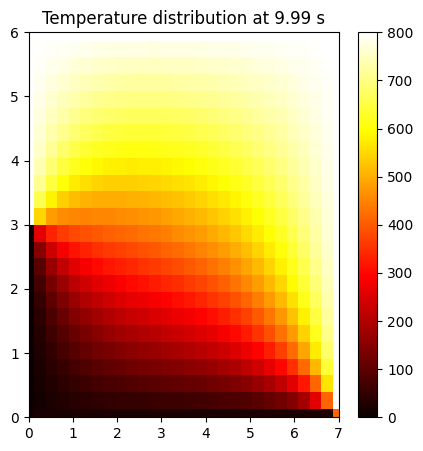

In [177]:
M = 6 * 4 # 0.25 mm
N = 7 * 4 # 0.25 mm
HEIGHT = 6 # cm
WIDTH = 7 # cm
DELTA_T = 0.01
T_END = 10
OUTPUT_NAME = 'temperature.gif'


def plot_heatmap(i: int,
                 heatmaps: np.ndarray, timestamps: np.ndarray,
                 ax: plt.Axes, fig: plt.Figure):
    print(f'{i + 1} frame processed!')
    heatmap = heatmaps[i]
    t = timestamps[i]
    y, x = np.meshgrid(np.linspace(0, HEIGHT, M), np.linspace(0, WIDTH, N))
    h_min, h_max = np.min(heatmap), np.max(heatmap)

    ax.clear()
    c = ax.pcolormesh(x, y, heatmap.T, cmap='hot', vmin=h_min, vmax=h_max)
    ax.set_title(f'Temperature distribution at {t:.2f} s')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax, cax=fig.axes[1] if len(fig.axes) > 1 else None)


def simulate(n: int):
    delta_x = WIDTH / N
    delta_y = HEIGHT / M
    cross_delta = (delta_x * delta_y) ** 2

    # Boundaries
    left = np.ones(M - 2) * 800
    left[:(M - 2) // 2] = np.zeros((M - 2) // 2)
    right = np.ones(M - 2) * 800
    up = np.ones(N - 2) * 800
    bottom = np.ones(N - 2) * 20

    t_mat = get_temperature_matrix(M - 2, N - 2, delta_x, delta_y, DELTA_T)
    t_mat_inv = np.linalg.inv(t_mat)
    boundary = get_boundary_vector(M - 2, N - 2, delta_x, delta_y, DELTA_T,
                                   left, right, up, bottom)

    # Set initial condition
    initial: np.ndarray = np.ones((M, N)) * 10
    initial[1:M - 1, 0] = left
    initial[1:M - 1, -1] = right
    initial[0, 1:N - 1] = bottom
    initial[-1, 1:N - 1] = up
    initial[0][0] = (initial[0][1] + initial[1][0]) / 2
    initial[0][-1] = (initial[0][-2] + initial[1][-1]) / 2
    initial[-1][0] = (initial[-1][1] + initial[-2][0]) / 2
    initial[-1][-1] = (initial[-2][-1] + initial[-1][-2]) / 2

    # Solve
    sol: List[np.ndarray] = [initial]
    timestamps = [0]
    for _ in range(n - 1):
        timestamps.append(timestamps[-1] + DELTA_T)
        sol.append(sol[-1].copy())
        inner = sol[-1][1:M - 1, 1:N - 1]
        new_inner = t_mat_inv \
            .dot(cross_delta * inner.flatten() + boundary) \
            .reshape((M - 2, N - 2))
        sol[-1][1:M - 1, 1:N - 1] = new_inner

    sol: np.ndarray = np.array(sol)
    timestamps: np.ndarray = np.array(timestamps)

    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    ani = FuncAnimation(
        fig, plot_heatmap,
        frames=len(sol), interval=100, repeat=False,
        fargs=(sol, timestamps, ax, fig)
    )
    print('Generation finished, saving...')
    ani.save(OUTPUT_NAME, dpi=300, writer=PillowWriter(fps=30))


simulate(int(T_END / DELTA_T))